So this notebook actually builds and trains two architectures: a dual decoder with cross attention (one decoder for gas the other for electricity, that both self and cross attend each other), and an encoder-dual-decoder which is the same but also includes an encoder block using temperature data as input and to which the decoder blocks also cross attend to.

Okay, so the structure for each sequential encoder-decoder (of which there will be two in parallel) will be:
1. input embedding
2. positional embedding
3. Initial decoder only block(s)
   1. pre-norm
   2. multi-head attention (masked)
   3. add (residual)
   4. pre-norm
   5. FF
   6. Add (residual)
4. decoder with cross attention blocks
   1. pre-norm
   2. multi-head attention (masked)
   3. add (residual)
   4. multi-head cross attention (masked) using key, values from initial decoder only block from parallel stream
   5. add & norm
   6. FF
   7. Add & norm
5. linear
6. softmax
7. output probabilities over the vocab_size

So, let's start by trying to make one of these.

In [59]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import numpy as np

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 8
n_head = 1
n_layer_do = 1 # number of decoder only layers
# n_layer_ca = 1 # number of cross-attention layers
dropout = 0.1

torch.manual_seed(1338)

In [100]:

# get the data
data = pd.read_csv('/Users/eoghan/repos/makemore/data/daily_demand_and_weather.csv')
# TODO: add <S> start of sequence token at each change of household_id, and align encoder context data with target, not input tokens
# to start, we will just work with the gas data, later we will complexify things by adding in electricity and weather, and information about the calender day
raw_gas = data['mean_rounded_gas_pulse'].copy()
raw_elec = data['mean_rounded_electric_combined'].copy()

# set all values less than 0 to 0
raw_gas.loc[raw_gas < 0] = 0
raw_elec.loc[raw_elec < 0] = 0

# set unreasonably high values to Nan
raw_gas.loc[raw_gas > 100000] = np.nan
raw_elec.loc[raw_elec > 100000] = np.nan

# so let's simplify the dataset, and round raw_gas to the nearest 10, just to reduce the size of our vocabulary. 
raw_gas = raw_gas.round(-1)
raw_elec = raw_elec.round(-1)

# first however we need to deal with missing values, in particular we need to replace any nan with a special character <M> which will represent missing values
raw_gas = raw_gas.astype(str).replace('nan', '<M>')
raw_elec = raw_elec.astype(str).replace('nan', '<M>')

#create a mapping from values to indices
unique_values_gas = raw_gas.unique()
vocab_size_gas = len(unique_values_gas)
unique_values_gas.sort()
vtoi_gas = {val:i for i, val in enumerate(unique_values_gas)}
itov_gas = {i:val for i, val in enumerate(unique_values_gas)}
encode_gas = lambda v: [vtoi_gas[val] for val in v] # take a list of values and return a list of indices
decode_gas = lambda l: [itov_gas[i] for i in l] # take a list of indices and return a list of values
data_gas = torch.tensor(encode_gas(raw_gas), dtype=torch.long)

# let's split the data into train and validation splits 0.9 / 0.1
#n = int(0.9*len(data_gas))
n = int(0.1*len(data_gas))
train_data_gas = data_gas[n:]
val_data_gas = data_gas[:n]

# and let's do the same for raw_elec
unique_values_elec = raw_elec.unique()
vocab_size_elec = len(unique_values_elec)
unique_values_elec.sort()
vtoi_elec = {val:i for i, val in enumerate(unique_values_elec)}
itov_elec = {i:val for i, val in enumerate(unique_values_elec)}
encode_elec = lambda v: [vtoi_elec[val] for val in v] # take a list of values and return a list of indices
decode_elec = lambda l: [itov_elec[i] for i in l] # take a list of indices and return a list of values
data_elec = torch.tensor(encode_elec(raw_elec), dtype=torch.long)
n = int(0.1*len(data_elec))
train_data_elec = data_elec[n:]
val_data_elec = data_elec[:n]

# add in contextual data, starting with the minimum temperature
# first we need to deal with missing values, in particular we need to replace any nan with a special character <M> which will represent missing values
data['mintemp'] = data['mintemp'].astype(str).replace('nan', '<M>')
unique_values_mintemp = data['mintemp'].unique()
vocab_size_mintemp = len(unique_values_mintemp)
unique_values_mintemp.sort()
vtoi_mintemp = {val:i for i, val in enumerate(unique_values_mintemp)}
itov_mintemp = {i:val for i, val in enumerate(unique_values_mintemp)}
encode_mintemp = lambda v: [vtoi_mintemp[val] for val in v] # take a list of values and return a list of indices
decode_mintemp = lambda l: [itov_mintemp[i] for i in l] # take a list of indices and return a list of values
data_mintemp = torch.tensor(encode_mintemp(data['mintemp']), dtype=torch.long)
n = int(0.1*len(data_mintemp))
train_data_mintemp = data_mintemp[n:]
val_data_mintemp = data_mintemp[:n]


In [106]:

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y for gas
    data = train_data_gas if split == 'train' else val_data_gas
    ix = torch.randint(len(data) - block_size, (batch_size,)) # ix max value is len(data) - block_size - 1
    x_gas = torch.stack([data[i:i+block_size] for i in ix]) # max index is len(data) - 1
    y_gas = torch.stack([data[i+1:i+block_size+1] for i in ix]) # max index is len(data)
    x_gas, y_gas = x_gas.to(device), y_gas.to(device)
    
    # now do the same for elec
    data = train_data_elec if split == 'train' else val_data_elec
    # ix = torch.randint(len(data) - block_size, (batch_size,)) # this was incorrect, we need to use the same indices for gas and elec
    x_elec = torch.stack([data[i:i+block_size] for i in ix])
    y_elec = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x_elec, y_elec = x_elec.to(device), y_elec.to(device)
    
    return x_gas, y_gas, x_elec, y_elec

def get_batch_encoder(split):
    # generate a small batch of data of inputs x and targets y for gas
    data = train_data_gas if split == 'train' else val_data_gas
    ix = torch.randint(len(data) - block_size, (batch_size,)) # ix max value is len(data) - block_size - 1
    x_gas = torch.stack([data[i:i+block_size] for i in ix]) # max index is len(data) - 1
    y_gas = torch.stack([data[i+1:i+block_size+1] for i in ix]) # max index is len(data)
    x_gas, y_gas = x_gas.to(device), y_gas.to(device)
    
    # now do the same for elec
    data = train_data_elec if split == 'train' else val_data_elec
    # ix = torch.randint(len(data) - block_size, (batch_size,)) # this was incorrect, we need to use the same indices for gas and elec
    x_elec = torch.stack([data[i:i+block_size] for i in ix])
    y_elec = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x_elec, y_elec = x_elec.to(device), y_elec.to(device)
    
    # get context data, start with mintemp 
    data = train_data_mintemp if split == 'train' else val_data_mintemp
    x_mintemp = torch.stack([data[i+1:i+block_size+1] for i in ix]) # we want to align the context data with the target data
    x_mintemp = x_mintemp.to(device)
    return x_gas, y_gas, x_elec, y_elec, x_mintemp

In [121]:
# estimate the loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters, 2)
        for k in range(eval_iters):
            X_gas, Y_gas, X_elec, Y_elec = get_batch(split)
            logits_gas, loss_gas, logits_elec, loss_elec = model(X_gas, X_elec, Y_gas, Y_elec)
            losses[k,0] = loss_gas.item()
            losses[k,1] = loss_elec.item()
        out[split] = torch.tensor([losses[:,0].mean().item(), losses[:,1].mean().item()])
    model.train()
    return out

@torch.no_grad()
def estimate_loss_encoder():
    out = {}
    em.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters, 2)
        for k in range(eval_iters):
            X_gas, Y_gas, X_elec, Y_elec, X_mintemp = get_batch_encoder(split)
            logits_gas, loss_gas, logits_elec, loss_elec = em(X_gas, X_elec, X_mintemp, Y_gas, Y_elec)
            losses[k,0] = loss_gas.item()
            losses[k,1] = loss_elec.item()
        out[split] = torch.tensor([losses[:,0].mean().item(), losses[:,1].mean().item()])
    em.train()
    return out

In [6]:
class MaskedHead(nn.Module):
    """ one head of masked self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [101]:
class Head(nn.Module):
    """ one head of unmasked self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [7]:
class MaskedCrossAttentionHead(nn.Module):
    """ one head of masked cross-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, kv):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = q.shape
        k = self.key(kv)   # (B,T,hs)
        q = self.query(q) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(kv) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [102]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class MultiHeadEncoderAttention(nn.Module):
    """ multiple heads of unmasked self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class MultiHeadCrossAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedCrossAttentionHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, kv):
        out = torch.cat([h(x, kv) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [9]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [103]:
class DecoderOnlyBlock(nn.Module):
    """ Decoder only transformer block: self-communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class EncoderOnlyBlock(nn.Module):
    """ Encoder transformer block: self-communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadEncoderAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class DecoderWithCrossAttentionBlock(nn.Module):
    """ Decoder with cross attention transformer block: self plus corss communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ca = MultiHeadCrossAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln_kv = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ln3 = nn.LayerNorm(n_embd)

    def forward(self, x, kv):
        # first masked self-attention layer with pre norm and residual connection
        x = x + self.sa(self.ln1(x))
        # cross attention layer with pre norm and residual connection
        x = x + self.ca(self.ln2(x), self.ln_kv(kv))
        x = x + self.ffwd(self.ln3(x))
        return x

In [58]:
class DualTransformerModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_gas = nn.Embedding(vocab_size_gas, n_embd)
        self.token_embedding_elec = nn.Embedding(vocab_size_elec, n_embd)
        self.position_embedding_gas = nn.Embedding(block_size, n_embd)
        self.position_embedding_elec = nn.Embedding(block_size, n_embd)
        self.do_blocks_gas = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        self.do_blocks_elec = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        # TODO: develop sequential cross attention blocks that allow multiple input arguments
        # self.ca_blocks_gas = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_elec = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        self.ca_blocks_gas = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        self.ca_blocks_elec = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        self.ln_f_gas = nn.LayerNorm(n_embd) # final layer norm
        self.ln_f_elec = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head_gas = nn.Linear(n_embd, vocab_size_gas)
        self.lm_head_elec = nn.Linear(n_embd, vocab_size_elec)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx_gas, idx_elec, targets_gas=None, targets_elec=None):
        B, T = idx_gas.shape # will be the same for idx_elec

        # idx_gas and targets_gas are both (B,T) tensor of integers
        # embedding and positional encoding layers
        tok_emb_gas = self.token_embedding_gas(idx_gas) # (B,T,C)
        tok_emb_elec = self.token_embedding_elec(idx_elec) # (B,T,C)
        pos_emb_gas = self.position_embedding_gas(torch.arange(T, device=device)) # (T,C)
        pos_emb_elec = self.position_embedding_elec(torch.arange(T, device=device)) # (T,C)
        x_gas = tok_emb_gas + pos_emb_gas # (B,T,C)
        x_elec = tok_emb_elec + pos_emb_elec # (B,T,C)
        # decoder only layers
        x_gas = self.do_blocks_gas(x_gas) # (B,T,C)
        x_elec = self.do_blocks_elec(x_elec) # (B,T,C)
        # cross attention layers
        x_gas = self.ca_blocks_gas(x_gas, x_elec) # (B,T,C)
        x_elec = self.ca_blocks_elec(x_elec, x_gas) # (B,T,C)
        # final output layers
        x_gas = self.ln_f_gas(x_gas) # (B,T,C)
        x_elec = self.ln_f_elec(x_elec) # (B,T,C)
        logits_gas = self.lm_head_gas(x_gas) # (B,T,vocab_size)
        logits_elec = self.lm_head_elec(x_elec) # (B,T,vocab_size)

        if targets_gas is None:
            loss_gas = None
        else:
            B, T, C = logits_gas.shape
            logits_gas = logits_gas.view(B*T, C)
            targets_gas = targets_gas.view(B*T)
            loss_gas = F.cross_entropy(logits_gas, targets_gas)
        # now the same for elec
        if targets_elec is None:
            loss_elec = None
        else:
            B, T, C = logits_elec.shape
            logits_elec = logits_elec.view(B*T, C)
            targets_elec = targets_elec.view(B*T)
            loss_elec = F.cross_entropy(logits_elec, targets_elec)

        return logits_gas, loss_gas, logits_elec, loss_elec

    def generate(self, idx_gas, idx_elec, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond_gas = idx_gas[:, -block_size:]
            idx_cond_elec = idx_elec[:, -block_size:]
            # get the predictions
            logits_gas, _, logits_elec, _ = self(idx_cond_gas, idx_cond_elec)
            # focus only on the last time step
            logits_gas = logits_gas[:, -1, :] # becomes (B, vocab_size)
            logits_elec = logits_elec[:, -1, :] # becomes (B, vocab_size)
            # apply softmax to get probabilities
            probs_gas = F.softmax(logits_gas, dim=-1) # (B, vocab_size)
            probs_elec = F.softmax(logits_elec, dim=-1) # (B, vocab_size)
            # sample from the distribution
            idx_next_gas = torch.multinomial(probs_gas, num_samples=1) # (B, 1)
            idx_next_elec = torch.multinomial(probs_elec, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx_gas = torch.cat((idx_gas, idx_next_gas), dim=1) # (B, T+1)
            idx_elec = torch.cat((idx_elec, idx_next_elec), dim=1) # (B, T+1)
        return idx_gas, idx_elec


In [134]:
class EncoderDualDecoderTransformerModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_gas = nn.Embedding(vocab_size_gas, n_embd)
        self.token_embedding_elec = nn.Embedding(vocab_size_elec, n_embd)
        self.token_embedding_mintemp = nn.Embedding(vocab_size_mintemp, n_embd)
        self.position_embedding_gas = nn.Embedding(block_size, n_embd)
        self.position_embedding_elec = nn.Embedding(block_size, n_embd)
        self.position_embedding_mintemp = nn.Embedding(block_size, n_embd)
        self.do_blocks_gas = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        self.do_blocks_elec = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        self.en_blocks_mintemp = nn.Sequential(*[EncoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        # TODO: develop sequential cross attention blocks that allow multiple input arguments
        # self.ca_blocks_gas = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_elec = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # a set of cross attention blocks to allow the gas and elec decoders to communicate with the mintemp encoder
        self.ca_blocks_gas_mintemp = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head)
        self.ca_blocks_elec_mintemp = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head)
        # a set of cross attention blocks to allow the gas and elec decoders to communicate
        self.ca_blocks_gas = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        self.ca_blocks_elec = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        self.ln_f_gas = nn.LayerNorm(n_embd) # final layer norm
        self.ln_f_elec = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head_gas = nn.Linear(n_embd, vocab_size_gas)
        self.lm_head_elec = nn.Linear(n_embd, vocab_size_elec)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx_gas, idx_elec, idx_mintemp, targets_gas=None, targets_elec=None):
        B, T = idx_gas.shape # will be the same for idx_elec
        B_en, T_en = idx_mintemp.shape
        # idx_gas and targets_gas are both (B,T) tensor of integers
        # embedding and positional encoding layers
        tok_emb_gas = self.token_embedding_gas(idx_gas) # (B,T,C)
        tok_emb_elec = self.token_embedding_elec(idx_elec) # (B,T,C)
        tok_emb_mintemp = self.token_embedding_mintemp(idx_mintemp) # (B_en,T_en,C)
        pos_emb_gas = self.position_embedding_gas(torch.arange(T, device=device)) # (T,C)
        pos_emb_elec = self.position_embedding_elec(torch.arange(T, device=device)) # (T,C)
        pos_emb_mintemp = self.position_embedding_mintemp(torch.arange(T_en, device=device)) # (T,C)
        x_gas = tok_emb_gas + pos_emb_gas # (B,T,C)
        x_elec = tok_emb_elec + pos_emb_elec # (B,T,C)
        x_mintemp = tok_emb_mintemp + pos_emb_mintemp # (B_en,T_en,C)
        # decoder only layers
        x_gas = self.do_blocks_gas(x_gas) # (B,T,C)
        x_elec = self.do_blocks_elec(x_elec) # (B,T,C)
        # encoder layers
        x_mintemp = self.en_blocks_mintemp(x_mintemp) # (B_en,T_en,C)
        # cross attention layers to allow the gas and elec decoders to communicate with the mintemp encoder
        x_gas = self.ca_blocks_gas_mintemp(x_gas, x_mintemp) # (B,T,C)
        x_elec = self.ca_blocks_elec_mintemp(x_elec, x_mintemp) # (B,T,C)
        # cross attention layers to allow the gas and elec decoders to communicate
        x_gas = self.ca_blocks_gas(x_gas, x_elec) # (B,T,C)
        x_elec = self.ca_blocks_elec(x_elec, x_gas) # (B,T,C)
        # final output layers
        x_gas = self.ln_f_gas(x_gas) # (B,T,C)
        x_elec = self.ln_f_elec(x_elec) # (B,T,C)
        logits_gas = self.lm_head_gas(x_gas) # (B,T,vocab_size)
        logits_elec = self.lm_head_elec(x_elec) # (B,T,vocab_size)

        if targets_gas is None:
            loss_gas = None
        else:
            B, T, C = logits_gas.shape
            logits_gas = logits_gas.view(B*T, C)
            targets_gas = targets_gas.view(B*T)
            loss_gas = F.cross_entropy(logits_gas, targets_gas)
        # now the same for elec
        if targets_elec is None:
            loss_elec = None
        else:
            B, T, C = logits_elec.shape
            logits_elec = logits_elec.view(B*T, C)
            targets_elec = targets_elec.view(B*T)
            loss_elec = F.cross_entropy(logits_elec, targets_elec)

        return logits_gas, loss_gas, logits_elec, loss_elec

    def generate(self, idx_gas, idx_elec, idx_mintemp):
        # Get the length of idx_mintemp
        mintemp_length = idx_mintemp.size(1) - block_size
        pad_token_id = 0
        # Iterate over the length of idx_mintemp
        for i in range(mintemp_length):
            # Crop idx to the last block_size tokens
            idx_cond_gas = idx_gas[:, -block_size:]
            idx_cond_elec = idx_elec[:, -block_size:]
            idx_cond_mintemp = idx_mintemp[:, i:i+block_size]

            # Pad idx_cond_gas and idx_cond_elec with a special token if they are shorter than idx_cond_mintemp
            if idx_cond_gas.size(1) < idx_cond_mintemp.size(1):
                padding = torch.full((idx_gas.size(0), idx_cond_mintemp.size(1) - idx_cond_gas.size(1)), pad_token_id, device=idx_gas.device)
                idx_cond_gas = torch.cat([padding, idx_cond_gas], dim=1)

            if idx_cond_elec.size(1) < idx_cond_mintemp.size(1):
                padding = torch.full((idx_elec.size(0), idx_cond_mintemp.size(1) - idx_cond_elec.size(1)), pad_token_id, device=idx_elec.device)
                idx_cond_elec = torch.cat([padding, idx_cond_elec], dim=1)

            # Get the predictions
            logits_gas, _, logits_elec, _ = self(idx_cond_gas, idx_cond_elec, idx_cond_mintemp)

            # Focus only on the last time step
            logits_gas = logits_gas[:, -1, :] # becomes (B, vocab_size)
            logits_elec = logits_elec[:, -1, :] # becomes (B, vocab_size)

            # Apply softmax to get probabilities
            probs_gas = F.softmax(logits_gas, dim=-1) # (B, vocab_size)
            probs_elec = F.softmax(logits_elec, dim=-1) # (B, vocab_size)

            # Sample from the distribution
            idx_next_gas = torch.multinomial(probs_gas, num_samples=1) # (B, 1)
            idx_next_elec = torch.multinomial(probs_elec, num_samples=1) # (B, 1)

            # Append sampled index to the running sequence
            idx_gas = torch.cat((idx_gas, idx_next_gas), dim=1) # (B, T+1)
            idx_elec = torch.cat((idx_elec, idx_next_elec), dim=1) # (B, T+1)

        return idx_gas, idx_elec


# Dual decoder model


In [110]:
model = DualTransformerModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss gas {losses['train'][0]:.4f}, val loss gas {losses['val'][0]:.4f}")
        print(f"step {iter}: train loss elec {losses['train'][1]:.4f}, val loss elec {losses['val'][1]:.4f}")

    # sample a batch of data
    xb_gas, yb_gas, xb_elec, yb_elec = get_batch('train')

    # evaluate the loss
    logits_gas, loss_gas, logits_elec, loss_elec = m(xb_gas, xb_elec, yb_gas, yb_elec)
    # combine the losses
    total_loss = loss_gas + loss_elec
    optimizer.zero_grad(set_to_none=True)
    total_loss.backward()
    optimizer.step()


0.049674 M parameters
step 0: train loss gas 7.8118, val loss gas 7.8093
step 0: train loss elec 5.4329, val loss elec 5.4357
step 300: train loss gas 6.6276, val loss gas 6.9212
step 300: train loss elec 4.3450, val loss elec 4.4068
step 600: train loss gas 6.0205, val loss gas 6.5858
step 600: train loss elec 4.0872, val loss elec 4.1693
step 900: train loss gas 5.9425, val loss gas 6.6137
step 900: train loss elec 3.9353, val loss elec 4.0855
step 1200: train loss gas 5.6792, val loss gas 6.5213
step 1200: train loss elec 3.7757, val loss elec 3.9274
step 1500: train loss gas 5.6928, val loss gas 6.2892
step 1500: train loss elec 3.6233, val loss elec 3.8834
step 1800: train loss gas 5.7631, val loss gas 6.4136
step 1800: train loss elec 3.6656, val loss elec 3.7997
step 2100: train loss gas 5.8143, val loss gas 6.3689
step 2100: train loss elec 3.7072, val loss elec 3.8192
step 2400: train loss gas 5.8340, val loss gas 6.5467
step 2400: train loss elec 3.7154, val loss elec 3.7850


In [111]:
# generate from the model
context_gas = torch.zeros((1, 1), dtype=torch.long, device=device)
context_elec = torch.zeros((1, 1), dtype=torch.long, device=device)
gen_gas, gen_elec = m.generate(context_gas, context_elec, max_new_tokens=len(raw_gas))
gen_gas = ['nan' if token == '<M>' else token for token in decode_gas(gen_gas[0].tolist())]
gen_elec = ['nan' if token == '<M>' else token for token in decode_elec(gen_elec[0].tolist())]
gen_data = {'gen_gas':gen_gas, 'gen_elec':gen_elec}
gen_df = pd.DataFrame(gen_data)
gen_df.to_csv('/Users/eoghan/repos/makemore/data/generated_data.csv', index=False)
gen_df.head()


,gen_gas,gen_elec
0,0.0,0.0
1,4350.0,710.0
2,8020.0,860.0
3,450.0,520.0
4,nan,1130.0


In [112]:
# let's do some basic evaluation of the generated data in comparison to the original data 
# to start, let's compare the means of the generated data to the original data
gen_gas = gen_df['gen_gas'].copy()
gen_elec = gen_df['gen_elec'].copy()
gen_gas.loc[gen_gas == 'nan'] = np.nan
gen_elec.loc[gen_elec == 'nan'] = np.nan
gen_gas = gen_gas.astype(float)
gen_elec = gen_elec.astype(float)
gen_gas_mean = gen_gas.mean()
gen_elec_mean = gen_elec.mean()
gen_gas.loc[gen_gas == 'nan'] = np.nan
gen_elec.loc[gen_elec == 'nan'] = np.nan
gen_gas = gen_gas.astype(float)
gen_elec = gen_elec.astype(float)
gen_gas_mean = gen_gas.mean()
gen_elec_mean = gen_elec.mean()
# there are some outliers in the original gas data, so let's get rid of values that are higher than 100000
orig_gas = data['mean_rounded_gas_pulse'].copy()
orig_elec = data['mean_rounded_electric_combined'].copy()
orig_gas.loc[orig_gas > 100000] = np.nan
orig_elec.loc[orig_elec > 100000] = np.nan
orig_gas_mean = orig_gas.mean()
orig_elec_mean = orig_elec.mean()
print(f'Original gas mean: {orig_gas_mean}, Generated gas mean: {gen_gas_mean}')
print(f'Original elec mean: {orig_elec_mean}, Generated elec mean: {gen_elec_mean}')
print(f'Original gas mean: {orig_gas_mean}, Generated gas mean: {gen_gas_mean}')
print(f'Original elec mean: {orig_elec_mean}, Generated elec mean: {gen_elec_mean}')

Original gas mean: 4158.306328052971, Generated gas mean: 3972.784956839137
Original elec mean: 372.75675432411754, Generated elec mean: 333.79647081521495


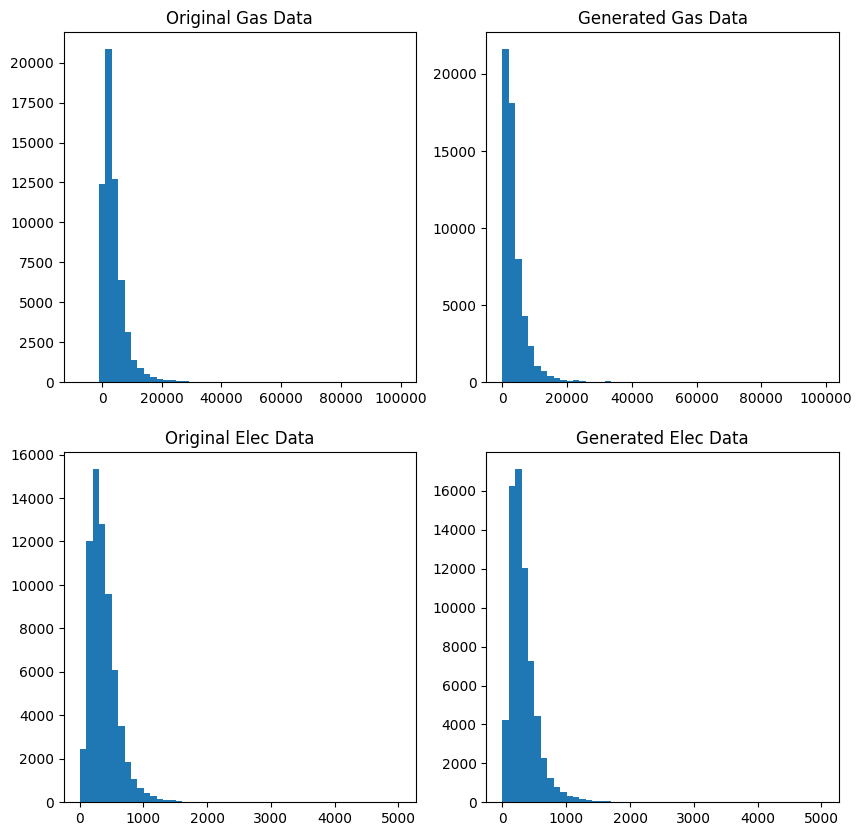

In [113]:
# now let's look at the distribution of the generated data in comparison to the original data
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(orig_gas, bins=50)
axs[0, 0].set_title('Original Gas Data')
axs[0, 1].hist(gen_gas, bins=50)
axs[0, 1].set_title('Generated Gas Data')
axs[1, 0].hist(orig_elec, bins=50)
axs[1, 0].set_title('Original Elec Data')
axs[1, 1].hist(gen_elec, bins=50)
axs[1, 1].set_title('Generated Elec Data')
plt.show()

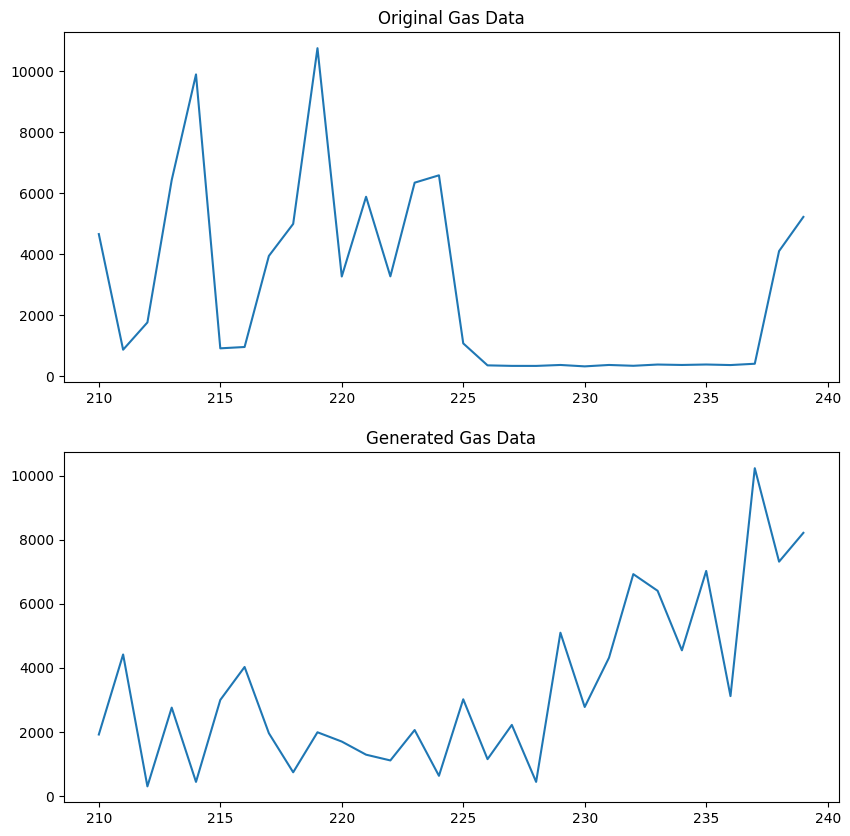

In [114]:
# let's start by just plotting 30 days of data
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(orig_gas[30*7:30*8])
axs[0].set_title('Original Gas Data')
axs[1].plot(gen_gas[30*7:30*8])
axs[1].set_title('Generated Gas Data')
plt.show()

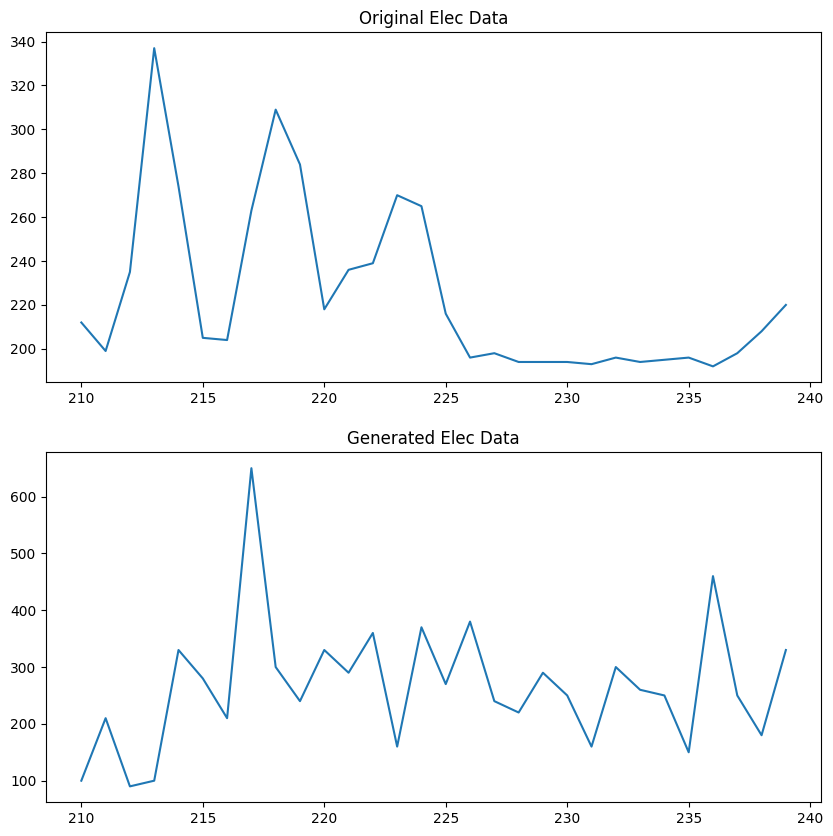

In [115]:
# let's do the same for electricity
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(orig_elec[30*7:30*8])
axs[0].set_title('Original Elec Data')
axs[1].plot(gen_elec[30*7:30*8])
axs[1].set_title('Generated Elec Data')
plt.show()

In [116]:
# compare amount of missing data in the generated data to the original data
gen_gas_missing = gen_gas.isnull().sum()
gen_elec_missing = gen_elec.isnull().sum()
orig_gas_missing = orig_gas.isnull().sum()
orig_elec_missing = orig_elec.isnull().sum()
print(f'Original gas missing: {orig_gas_missing}, Generated gas missing: {gen_gas_missing}')
print(f'Original elec missing: {orig_elec_missing}, Generated elec missing: {gen_elec_missing}')

Original gas missing: 11951, Generated gas missing: 13800
Original elec missing: 4945, Generated elec missing: 4226


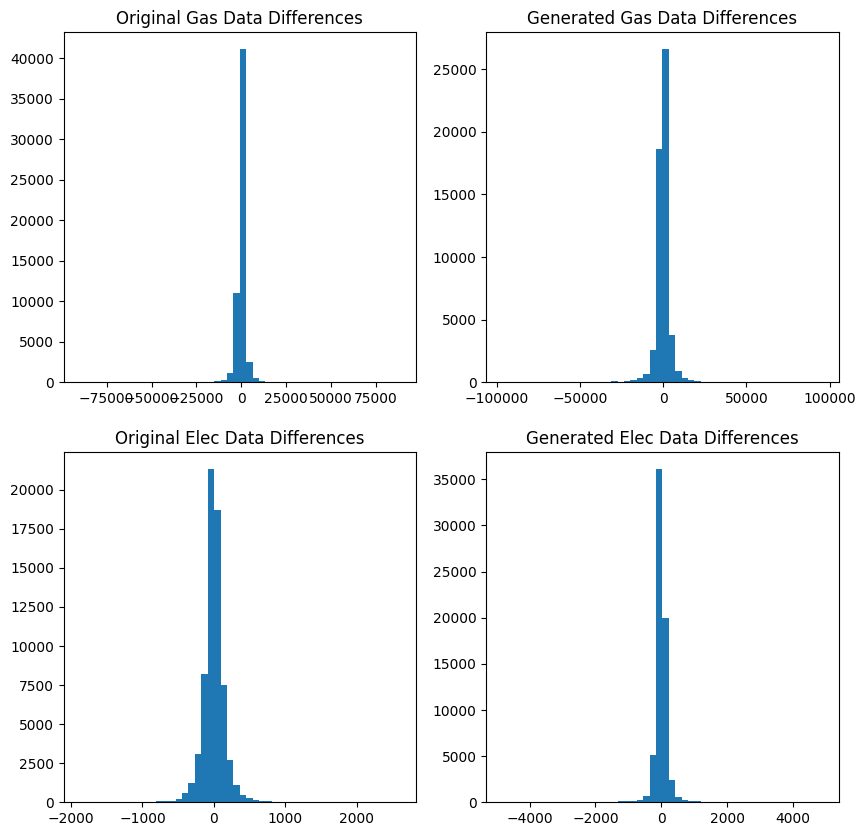

In [117]:
# calculate the change in values between each time step, and then compare distributions of these changes between the original and generated data
orig_gas_diff = orig_gas.diff()
gen_gas_diff = gen_gas.diff()
orig_elec_diff = orig_elec.diff()
gen_elec_diff = gen_elec.diff()
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(orig_gas_diff, bins=50)
axs[0, 0].set_title('Original Gas Data Differences')
axs[0, 1].hist(gen_gas_diff, bins=50)
axs[0, 1].set_title('Generated Gas Data Differences')
axs[1, 0].hist(orig_elec_diff, bins=50)
axs[1, 0].set_title('Original Elec Data Differences')
axs[1, 1].hist(gen_elec_diff, bins=50)
axs[1, 1].set_title('Generated Elec Data Differences')
plt.show()


In summary, considering how simple this network is, the results are quite remarkable in terms of the similarity of the generated to original data. 

One concern is data duplication, i.e. where the model is just mirroring the input data, which is a concern for data privacy perspective. 


In [ ]:
# TODO: We should check that there is no sequences of data that are duplicated. Or rather, to what extent are there sequences of increasing length duplicated?

# Encoder Dual Decoder model

In [135]:
encoder_model = EncoderDualDecoderTransformerModel()
em = encoder_model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in em.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
encoder_optimizer = torch.optim.AdamW(em.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss_encoder()
        print(f"step {iter}: train loss gas {losses['train'][0]:.4f}, val loss gas {losses['val'][0]:.4f}")
        print(f"step {iter}: train loss elec {losses['train'][1]:.4f}, val loss elec {losses['val'][1]:.4f}")

    # sample a batch of data
    xb_gas, yb_gas, xb_elec, yb_elec, xb_mintemp = get_batch_encoder('train')

    # evaluate the loss
    logits_gas, loss_gas, logits_elec, loss_elec = em(xb_gas, xb_elec, xb_mintemp, yb_gas, yb_elec)
    # combine the losses
    total_loss = loss_gas + loss_elec
    encoder_optimizer.zero_grad(set_to_none=True)
    total_loss.backward()
    encoder_optimizer.step()

0.053026 M parameters
step 0: train loss gas 7.8165, val loss gas 7.8149
step 0: train loss elec 5.4289, val loss elec 5.4283
step 300: train loss gas 6.6872, val loss gas 6.8694
step 300: train loss elec 4.3642, val loss elec 4.3830
step 600: train loss gas 6.0950, val loss gas 6.6836
step 600: train loss elec 4.1712, val loss elec 4.2157
step 900: train loss gas 6.0261, val loss gas 6.4250
step 900: train loss elec 3.8993, val loss elec 3.9992
step 1200: train loss gas 5.7233, val loss gas 6.4248
step 1200: train loss elec 3.6978, val loss elec 3.9774
step 1500: train loss gas 5.9542, val loss gas 6.4887
step 1500: train loss elec 3.6694, val loss elec 3.8467
step 1800: train loss gas 5.7397, val loss gas 6.4298
step 1800: train loss elec 3.6536, val loss elec 3.8477
step 2100: train loss gas 5.6751, val loss gas 6.3468
step 2100: train loss elec 3.7316, val loss elec 3.8783
step 2400: train loss gas 5.7513, val loss gas 6.2100
step 2400: train loss elec 3.6810, val loss elec 3.8063


Similar training loss to the dual decoder only. The training loss is bouncing around a bit, and so this seems like the training rate needs to decay. So definitely some work needed to optimise the training parameters. 

In [136]:
# generate from the model
context_gas = torch.zeros((1, 1), dtype=torch.long, device=device)
context_elec = torch.zeros((1, 1), dtype=torch.long, device=device)
context_mintemp = data_mintemp.unsqueeze(0) # we'll use the original mintemp data as the context
engen_gas, engen_elec = em.generate(context_gas, context_elec, context_mintemp)
engen_gas = ['nan' if token == '<M>' else token for token in decode_gas(engen_gas[0].tolist())]
engen_elec = ['nan' if token == '<M>' else token for token in decode_elec(engen_elec[0].tolist())]


,engen_gas,engen_elec
0,0.0,0.0
1,3840.0,550.0
2,1490.0,510.0
3,12220.0,480.0
4,5090.0,340.0


In [ ]:
engen_mintemp = ['nan' if token == '<M>' else token for token in decode_mintemp(context_mintemp[0].tolist())]


In [144]:
engen_data = {'engen_gas':[0,0,0]+engen_gas, 'engen_elec':[0,0,0]+engen_elec, 'engen_mintemp':engen_mintemp}
engen_df = pd.DataFrame(engen_data)
engen_df.to_csv('/Users/eoghan/repos/makemore/data/encoder_generated_data.csv', index=False)
engen_df.head()


,engen_gas,engen_elec,engen_mintemp
0,0,0,4.0
1,0,0,5.0
2,0,0,3.0
3,0.0,0.0,7.0
4,3840.0,550.0,6.0


In [164]:
# TODO: compare the generated data to the original data visually
# the original data
# there are some outliers in the original gas data, so let's get rid of values that are higher than 100000
orig_gas = data['mean_rounded_gas_pulse'].copy()
orig_elec = data['mean_rounded_electric_combined'].copy()
orig_gas.loc[orig_gas > 100000] = np.nan
orig_elec.loc[orig_elec > 100000] = np.nan
# generated data
engen_gas = engen_df['engen_gas'].copy()
engen_elec = engen_df['engen_elec'].copy()
engen_mintemp = engen_df['engen_mintemp'].copy()
engen_gas.loc[engen_gas == 'nan'] = np.nan
engen_elec.loc[engen_elec == 'nan'] = np.nan
engen_mintemp.loc[engen_mintemp == 'nan'] = np.nan
engen_gas = engen_gas.astype(float)
engen_elec = engen_elec.astype(float)
engen_mintemp = engen_mintemp.astype(float)
engen_gas_mean = engen_gas.mean()
engen_elec_mean = engen_elec.mean()
print(f'Original gas mean: {orig_gas_mean}, Generated gas mean: {engen_gas_mean}')
print(f'Original elec mean: {orig_elec_mean}, Generated elec mean: {engen_elec_mean}')
print(f'Mean mintemp: {engen_mintemp.mean()}')


Original gas mean: 4158.306328052971, Generated gas mean: 4798.628138481943
Original elec mean: 372.75675432411754, Generated elec mean: 391.04637250803626
Mean mintemp: 5.705782398761756


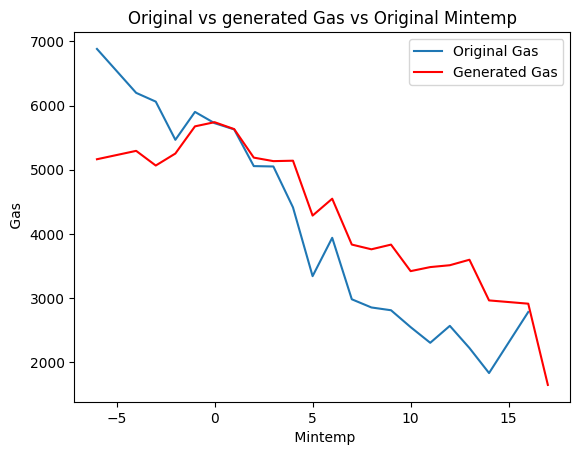

In [171]:
# temperature data
orig_mintemp = engen_df['engen_mintemp'].copy()
orig_mintemp.loc[orig_mintemp == 'nan'] = np.nan
orig_mintemp = orig_mintemp.astype(float)

# i want to display the relationship between orig_gas and orig_mintemp, there are however over 70k data points, so let's do a groupby average
# Pair orig_gas and orig_mintemp together
temp_data = pd.DataFrame({'orig_gas': orig_gas, 'orig_mintemp': orig_mintemp})
temp_data2 = pd.DataFrame({'engen_gas': engen_gas, 'engen_mintemp': engen_mintemp})
# groupby orig_mintemp and get the average orig_gas
grouped = temp_data.groupby('orig_mintemp').mean().reset_index()
grouped_gen = temp_data2.groupby('engen_mintemp').mean().reset_index()
grouped_gen = grouped_gen.sort_values(by='engen_mintemp')
plt.plot(grouped['orig_mintemp'], grouped['orig_gas'], label='Original Gas')
plt.plot(grouped_gen['engen_mintemp'], grouped_gen['engen_gas'], color='red',label='Generated Gas')
plt.xlabel(' Mintemp')
plt.ylabel(' Gas')
plt.title('Original vs generated Gas vs Original Mintemp')
plt.legend()
plt.show()


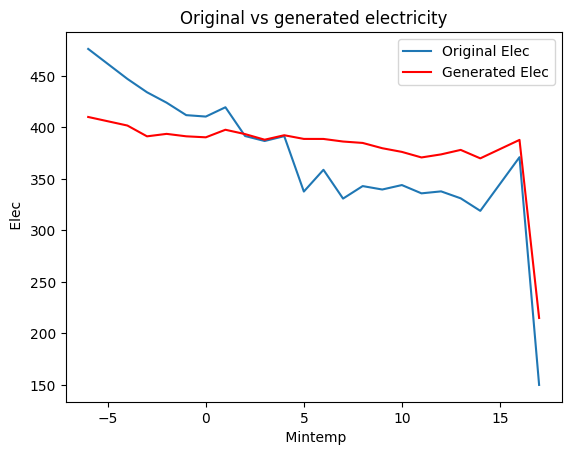

In [170]:
# let's do the same for electricity
temp_data = pd.DataFrame({'orig_elec': orig_elec, 'orig_mintemp': orig_mintemp})
temp_data2 = pd.DataFrame({'engen_elec': engen_elec, 'engen_mintemp': engen_mintemp})
# groupby orig_mintemp and get the average orig_elec
grouped = temp_data.groupby('orig_mintemp').mean().reset_index()
grouped_gen = temp_data2.groupby('engen_mintemp').mean().reset_index()
grouped_gen = grouped_gen.sort_values(by='engen_mintemp')
plt.plot(grouped['orig_mintemp'], grouped['orig_elec'], label='Original Elec')
plt.plot(grouped_gen['engen_mintemp'], grouped_gen['engen_elec'], color='red',label='Generated Elec')
plt.xlabel(' Mintemp')
plt.ylabel(' Elec')
plt.title('Original vs generated electricity')
plt.legend()
plt.show()